Intrusion Detection with Machine Learning

In [79]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import  OneHotEncoder , FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score ,classification_report,confusion_matrix


## Dataset
The data used in this project can be found on Kaggle:  
[Intrusion detection Data Set](https://www.kaggle.com/datasets/dnkumars/cybersecurity-intrusion-detection-dataset/data)


Read Data 

In [80]:
data = pd.read_csv("https://raw.githubusercontent.com/mhamadAlhajj/ML-intrusion-detector/main/cybersecurity_intrusion_data.csv")
data = data.drop("session_id",axis=1)

Data Overview

In [81]:
print(data.shape)
print(data.info())
print(data.describe())

(9537, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   network_packet_size  9537 non-null   int64  
 1   protocol_type        9537 non-null   object 
 2   login_attempts       9537 non-null   int64  
 3   session_duration     9537 non-null   float64
 4   encryption_used      7571 non-null   object 
 5   ip_reputation_score  9537 non-null   float64
 6   failed_logins        9537 non-null   int64  
 7   browser_type         9537 non-null   object 
 8   unusual_time_access  9537 non-null   int64  
 9   attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 745.2+ KB
None
       network_packet_size  login_attempts  session_duration  \
count          9537.000000     9537.000000       9537.000000   
mean            500.430639        4.032086        792.745312   
std             198.3

    Shape: 
The dataset contains 9537 rows and 11 columns.

    info :
There are no null values in our dataset.

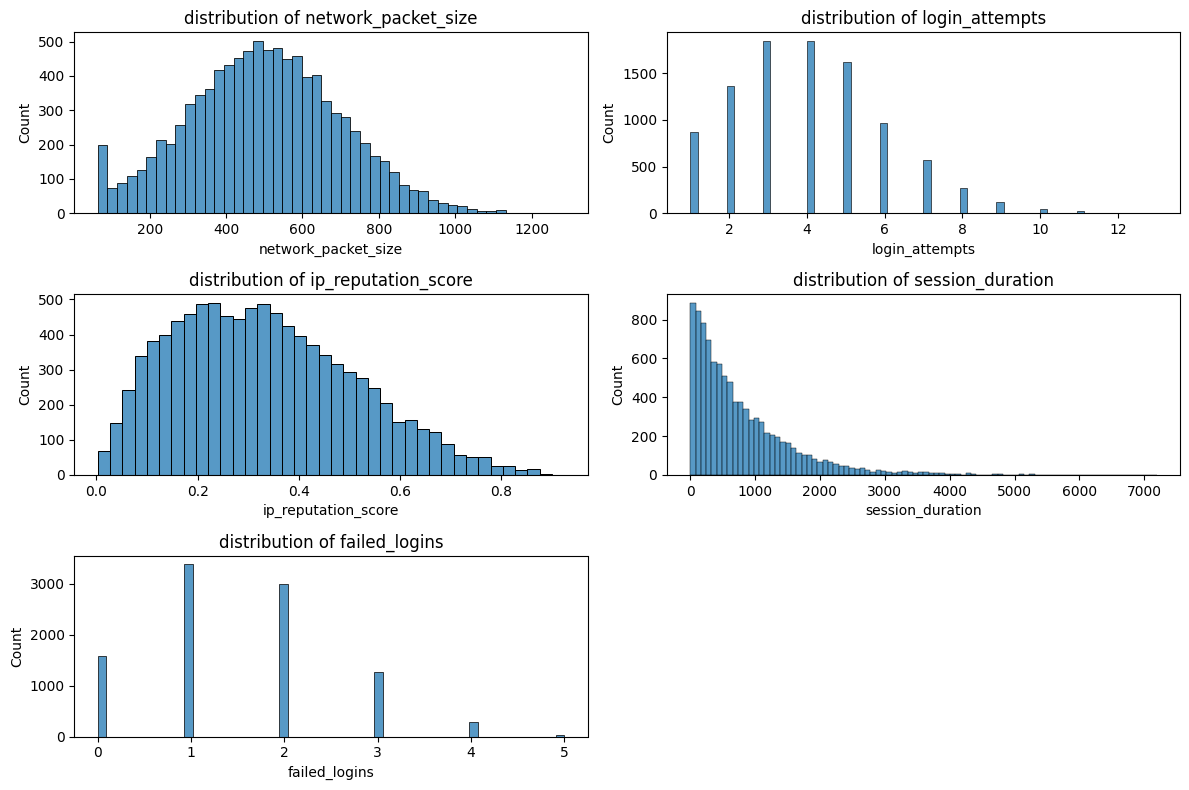

In [82]:
columns_to_display=["network_packet_size","login_attempts","ip_reputation_score","session_duration","failed_logins"]
plt.figure(figsize=(12, 8))
nrows=int(np.ceil(len(columns_to_display)/2))
for index,column in enumerate(columns_to_display):
    plt.subplot(nrows,2,index+1)
    sns.histplot(data[column])
    plt.title(f"distribution of {column}")

plt.tight_layout()
plt.show()

all histograms show right-skewed 



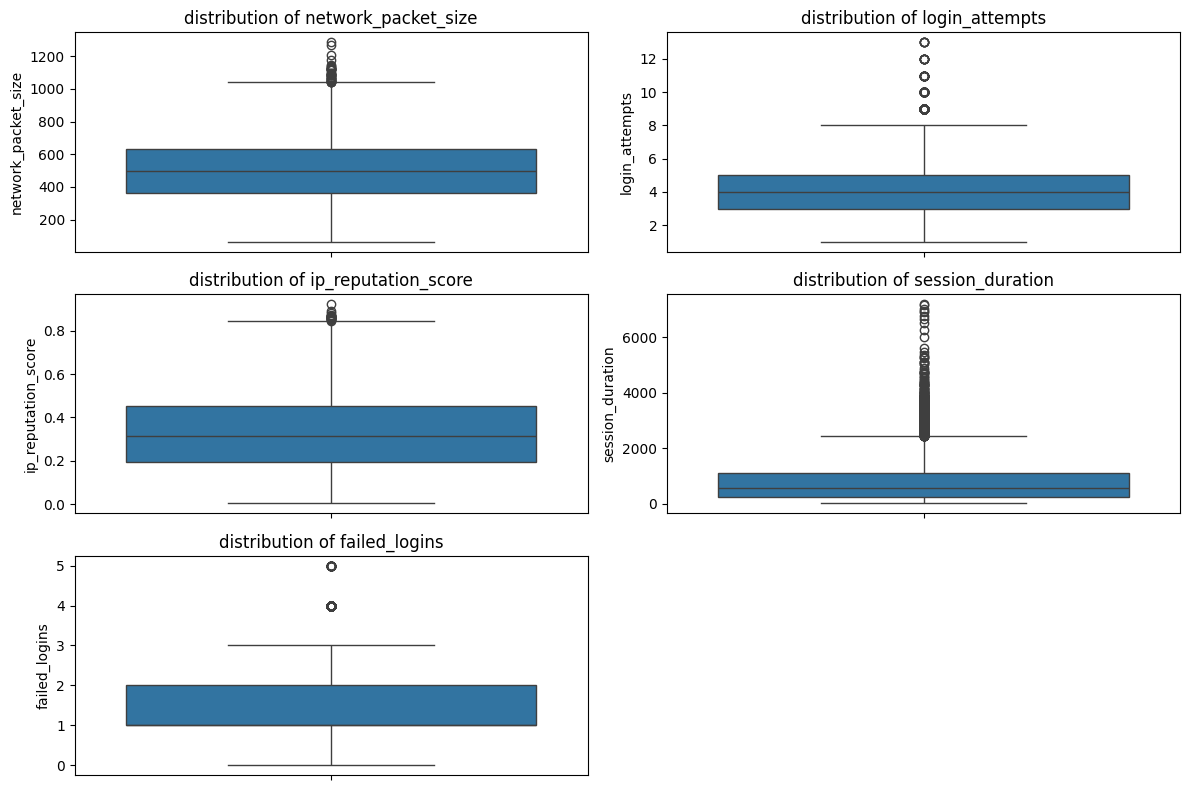

In [83]:
plt.figure(figsize=(12,8))
nrows=int(np.ceil(len(columns_to_display)/2))
for index , column in enumerate(columns_to_display):
    plt.subplot(nrows,2,index+1)
    sns.boxplot(data[column])
    plt.title(f"distribution of {column}")
plt.tight_layout()
plt.show()

Network packet size and session duration show several outliers .

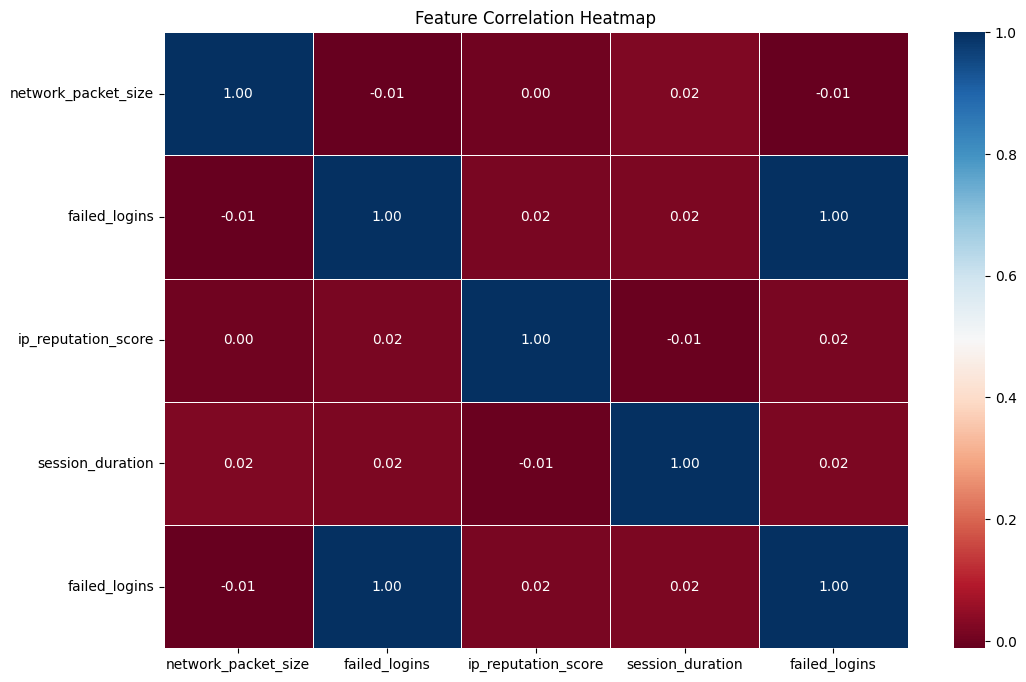

In [84]:
plt.figure(figsize=(12, 8))
sns.heatmap(data[["network_packet_size","failed_logins","ip_reputation_score","session_duration","failed_logins"]].corr(),cmap='RdBu',annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

As we can see, there are no relationships between the columns.

So, we should use a model that can handle data without strong relationships between features.

best params are : {'classifier__max_depth': 7, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}
accuracy_score = 0.8948287910552062

classification report :
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      1576
           1       1.00      0.77      0.87      1286

    accuracy                           0.89      2862
   macro avg       0.92      0.88      0.89      2862
weighted avg       0.91      0.89      0.89      2862



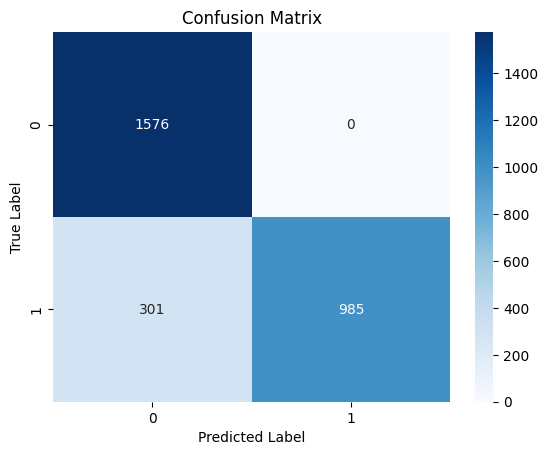

In [86]:
features=data.drop("attack_detected",axis=1)
target=data['attack_detected']

X_train , X_test , y_train , y_test = train_test_split(features,target,test_size=0.3,random_state=42)
numeric_features=["network_packet_size","failed_logins","ip_reputation_score","session_duration","failed_logins"]
categorical_features= X_train.select_dtypes(include="object").columns
preprocessor = ColumnTransformer(transformers=[('num',Pipeline(steps=[('log',FunctionTransformer(np.log1p,validate=False))]),numeric_features) ,
                                            ('cat' , OneHotEncoder(handle_unknown='ignore'),categorical_features)],remainder="passthrough")

pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                        ('classifier',DecisionTreeClassifier(random_state=42))
                        ])
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search_cv=GridSearchCV(pipeline,param_grid,cv=5,scoring="f1",n_jobs=-1)
grid_search_cv.fit(X_train,y_train)
print(f"best params are : {grid_search_cv.best_params_}")
best_dt=grid_search_cv.best_estimator_
y_pred=best_dt.predict(X_test)
print(f"accuracy_score = {accuracy_score(y_test,y_pred)}")
print("\nclassification report :\n",classification_report(y_test,y_pred))

cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Since we want to detect whether a login is an attack or not, False Negatives are of particular concern. We can observe that the number of False Negatives is quite high . 